In [1]:
from dataset import TextDataset
from lstm import LSTMModel
from tokenizer import merge_text_files
from utils import add_special_tokens, collate_fn
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
import sentencepiece as spm

In [2]:
TOKENIZER_PATH = "bpe_tokenizer.model"
TRAIN_FILE = "data/train.jsonl"
VAL_FILE = "data/test.jsonl"
MAX_SEQ_LEN = 512
BATCH_SIZE = 128
EMBEDD_DIM = 256
HIDDEN_DIM = 768
NUM_LAYERS = 2
DROPOUT = 0.2
LEARNING_RATE = 0.001
EPOCHS = 100
torch.cuda.get_device_name(0)

'NVIDIA A100 80GB PCIe'

In [3]:
model = LSTMModel(
    vocab_size=10000,
    embedding_dim=EMBEDD_DIM,
    hidden_dim=HIDDEN_DIM,
    num_layers=NUM_LAYERS,
    dropout=DROPOUT,
)


In [4]:
def train_model(model=None, name=None):
    """
    Training the model.
    """

    device = torch.device('mps' if torch.backends.mps.is_available() else 'cuda' if torch.cuda.is_available() else 'cpu')
    print(f"Using device: {device}")
    # Load the tokenizer
    tokenizer = spm.SentencePieceProcessor(model_file='bpe_tokenizer.model')
    vocab_size = tokenizer.get_piece_size()

    # Load the dataset
    train_dataset = TextDataset(TRAIN_FILE, tokenizer, MAX_SEQ_LEN)
    val_dataset = TextDataset(VAL_FILE, tokenizer, MAX_SEQ_LEN)

    # Create DataLoader
    train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, collate_fn=collate_fn)
    val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, collate_fn=collate_fn)


    model = model.to(device)

    # optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)
    optimizer = optim.AdamW(model.parameters(), lr=LEARNING_RATE, weight_decay=1e-4)
    # optimizer = optim.AdamW(model.parameters(), lr=0.01, weight_decay=1e-4)

    scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, "min", patience=1, factor=0.5, verbose=True)
    criterion = nn.CrossEntropyLoss(ignore_index=3)  # Ignore padding index

    best_val_loss = float('inf')
    no_improve_epochs = 0
    train_losses, val_losses = [], []

    for epoch in range(EPOCHS):
        model.train()
        total_train_loss = 0

        for input_ids, target_ids in train_loader:
            input_ids, target_ids = input_ids.to(device), target_ids.to(device)

            optimizer.zero_grad()

            logits, _ = model(input_ids)
            loss = criterion(logits.view(-1, vocab_size), target_ids.view(-1))
            loss.backward()
            optimizer.step()

            total_train_loss += loss.item()

        avg_train_loss = total_train_loss / len(train_loader)
        train_losses.append(avg_train_loss)
        print(f"Epoch {epoch + 1}/{EPOCHS}, Train Loss: {avg_train_loss:.4f}")

        # Validation
        model.eval()
        total_val_loss = 0
        with torch.no_grad():
            for input_ids, target_ids in val_loader:
                input_ids, target_ids = input_ids.to(device), target_ids.to(device)


                logits, _ = model(input_ids)
                loss = criterion(logits.view(-1, vocab_size), target_ids.view(-1))
                total_val_loss += loss.item()
        avg_val_loss = total_val_loss / len(val_loader)
        val_losses.append(avg_val_loss)
        print(f"Epoch {epoch + 1}/{EPOCHS}, Validation Loss: {avg_val_loss:.4f}")
        scheduler.step(avg_val_loss)
        # Early stopping
        if avg_val_loss < best_val_loss:
            best_val_loss = avg_val_loss
            no_improve_epochs = 0
            torch.save(model.state_dict(), f"best_models/best_model_{name}.pth")
            print("Model saved.")
        else:
            no_improve_epochs += 1
            if no_improve_epochs >= 3:
                print("Early stopping triggered.")
                break
    print("Training complete.")
    return train_losses, val_losses


In [5]:
train_losses, val_losses = train_model(model, model._get_name())

Using device: cuda


/home/madrez/.conda/envs/fai/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Epoch 1/100, Train Loss: 6.5160
Epoch 1/100, Validation Loss: 5.9301
Model saved.
Epoch 2/100, Train Loss: 5.6497
Epoch 2/100, Validation Loss: 5.4482
Model saved.
Epoch 3/100, Train Loss: 5.3168
Epoch 3/100, Validation Loss: 5.2082
Model saved.
Epoch 4/100, Train Loss: 5.1041
Epoch 4/100, Validation Loss: 5.0467
Model saved.
Epoch 5/100, Train Loss: 4.9492
Epoch 5/100, Validation Loss: 4.9283
Model saved.
Epoch 6/100, Train Loss: 4.8304
Epoch 6/100, Validation Loss: 4.8414
Model saved.
Epoch 7/100, Train Loss: 4.7297
Epoch 7/100, Validation Loss: 4.7721
Model saved.
Epoch 8/100, Train Loss: 4.6413
Epoch 8/100, Validation Loss: 4.7129
Model saved.
Epoch 9/100, Train Loss: 4.5601
Epoch 9/100, Validation Loss: 4.6610
Model saved.
Epoch 10/100, Train Loss: 4.4844
Epoch 10/100, Validation Loss: 4.6185
Model saved.
Epoch 11/100, Train Loss: 4.4146
Epoch 11/100, Validation Loss: 4.5815
Model saved.
Epoch 12/100, Train Loss: 4.3487
Epoch 12/100, Validation Loss: 4.5545
Model saved.
Epoch 13/1

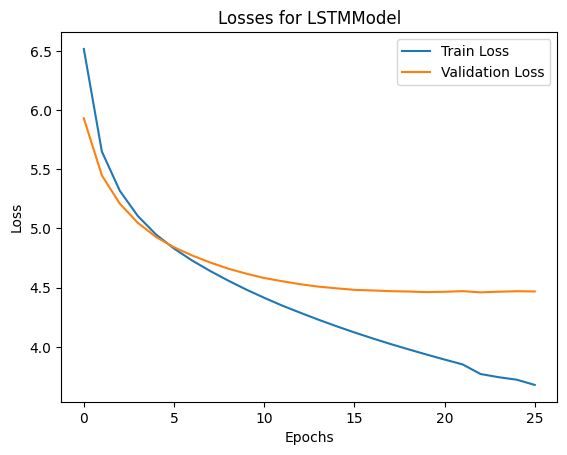

In [6]:
import matplotlib.pyplot as plt
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title(f'Losses for {model._get_name()}')
plt.legend()
plt.savefig(f"best_models/img/losses_{model._get_name()}.png")
plt.show()

In [7]:
# save losses
import json
with open(f"best_models/loss/losses_{model._get_name()}.json", "w") as f:
    json.dump({"train": train_losses, "val": val_losses}, f)

In [4]:
model.load_state_dict(torch.load("best_models/pth/best_model_LSTMModel.pth"))
device="cuda"
model.to(device)
model.eval()

LSTMModel(
  (embedding): Embedding(10000, 256, padding_idx=0)
  (lstm): LSTM(256, 768, num_layers=2, batch_first=True, dropout=0.2)
  (fc): Linear(in_features=768, out_features=10000, bias=True)
)

In [5]:
import sentencepiece as spm
TOKENIZER_PATH = "bpe_tokenizer.model"
tokenizer = spm.SentencePieceProcessor(model_file=TOKENIZER_PATH)
prompt = "Which do you prefer? Dogs or cats?"
model.generate(tokenizer, prompt, device="cuda")

'<eos> thought! And here Tshins letter made by a big male gloved husband poppedbeod, and then trotted and combed. If one has. Some thought: Give him back your inn height, said Neville, sat'

In [6]:
prompt = "Once upon a time..."
model.generate(tokenizer, prompt, device="cuda")

'Hayde! cried the count. Your excellency, really, you understand, murmured Pierre, to blame the count pronounced to prove all this: my affair help her from my ownator.<eos>! but she firmly felt about it even in the'

In [7]:
from dataset import TextDataset
from utils import collate_fn
from torch.utils.data import DataLoader
from tqdm import tqdm

MAX_SEQ_LEN = 128
BATCH_SIZE = 128

val_dataset = TextDataset(VAL_FILE, tokenizer, MAX_SEQ_LEN)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, collate_fn=collate_fn)



from nltk.translate.bleu_score import sentence_bleu, SmoothingFunction
from tqdm import tqdm

import math
criterion = nn.CrossEntropyLoss(ignore_index=3)
vocab_size = 10000
device="cuda"
def evaluate_ppl(model, data_loader, criterion, vocab_size):
    model.eval()
    total_loss = 0
    with torch.no_grad():
        for inputs, targets in tqdm(data_loader, desc="Calculating Perplexity"):
            inputs, targets = inputs.to(device), targets.to(device)
            outputs, _ = model(inputs)
            outputs = outputs.view(-1, vocab_size)
            targets = targets.view(-1)
            loss = criterion(outputs, targets)
            total_loss += loss.item()
    avg_loss = total_loss / len(data_loader)
    ppl = math.exp(avg_loss)
    return ppl

def evaluate_bleu(model, dataset, sp, num_samples=1000):
    model.eval()
    smoothie = SmoothingFunction().method4
    scores = []

    for i in tqdm(range(min(len(dataset), num_samples)), desc="Calculating BLEU"):
        full_text = dataset.data[i]
        # full_text = dataset.samples[i]
        prompt = full_text[:50]
        reference = full_text[50:100]
        generated_text = model.generate(tokenizer, prompt, device="cuda")

        # Compare generated text to the actual continuation
        score = sentence_bleu(
            [reference.split()],
            generated_text.split(),
            smoothing_function=smoothie
        )
        scores.append(score)

    return sum(scores) / len(scores)
# Evaluate on test set
test_loader = DataLoader(val_dataset, batch_size=32, shuffle=False, collate_fn=collate_fn)
ppl = evaluate_ppl(model, test_loader, criterion, vocab_size)
bleu = evaluate_bleu(model, val_dataset, tokenizer)

print(f"\nTest Perplexity: {ppl:.4f}")
print(f"Average BLEU Score (1000 samples): {bleu:.4f}")

Calculating BLEU: 100%|██████████| 1000/1000 [00:20<00:00, 48.46it/s]


Test Perplexity: 86.2531
Average BLEU Score (1000 samples): 0.0073
